In [114]:
import pandas as pd
import numpy as np
import random
from numpy import random

data = pd.read_csv('data/result.csv', parse_dates=['time'], index_col=['time'])
data

,outdoor_temp,zone_temp,occupancy,supply_temp,air_flow
time,,,,,
2017-01-01 00:00:00,2.200,22.832449,0,25.000003,0.733767
2017-01-01 00:05:00,1.825,22.824465,0,25.000003,0.733767
2017-01-01 00:10:00,1.450,22.812760,0,25.000003,0.733767
2017-01-01 00:15:00,1.075,22.799019,0,25.000003,0.733767
2017-01-01 00:20:00,0.700,22.784421,0,25.000003,0.733767
...,...,...,...,...,...
2017-12-31 23:40:00,6.000,22.990503,0,25.000004,0.733767
2017-12-31 23:45:00,6.000,22.988552,0,25.000004,0.733767
2017-12-31 23:50:00,6.000,22.986715,0,25.000004,0.733767


In [115]:
train_data = data.loc['2017-07-04 00:00:00':'2017-07-10 22:35:00']
test_data = data.loc['2017-07-11 00:00:00':'2017-07-11 23:55:00']

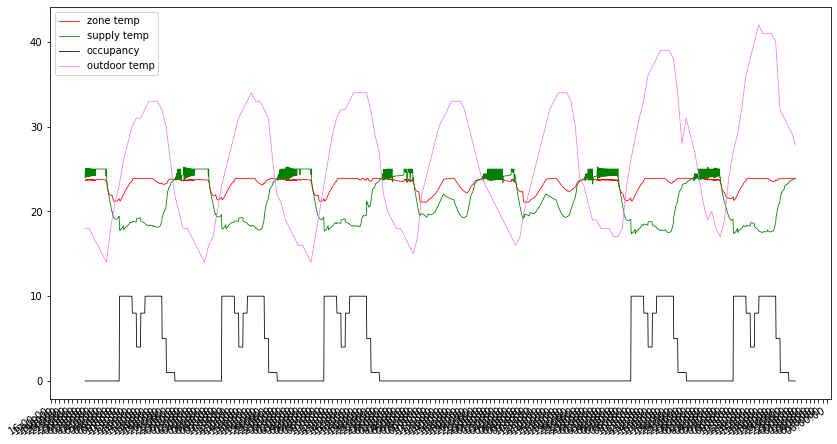

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

fig, ax = plt.subplots()
hours = mdates.HourLocator(interval = 1)
h_fmt = mdates.DateFormatter('%H:%M:%S')

ax.plot(train_data.index, train_data['zone_temp'].values, color = 'red', linewidth = 0.8, label = 'zone temp')
ax.plot(train_data.index, train_data['supply_temp'].values, color = 'green', linewidth = 0.8, label = 'supply temp')
ax.plot(train_data.index, train_data['occupancy'].values, color = 'black', linewidth = 0.8, label = 'occupancy')
ax.plot(train_data.index, train_data['outdoor_temp'].values, color = 'violet', linewidth = 0.8, label = 'outdoor temp')
#Then tick and format with matplotlib:
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)

fig.autofmt_xdate()
fig.set_size_inches(14, 8)
plt.legend()
plt.show()

In [116]:
##Faults:
# 1. Offset Fault: x' = a + x + err
# 2. Gain Fault: x' = Bx+ err
# 3. Stuck at Fault: x' = a
# 4. Out-of-bound: x'<theta1 and x'>theta2

def simulateFault(sensedValues, att, params):
    end_fault_index = int(len(sensedValues) * 0.5)
    interval = end_fault_index/4
    BMS = []
    true_values = []
    BMS_final = []
    classification = []
    
    noise = random.rand(len(sensedValues[att])) * 0.5

    for i in range(0, len(sensedValues)):
        if i <= interval:
            a = params['constant'] 
            sensedValues[att][i] = noise[i] + a + sensedValues[att][i]
            classification.append(1)

        elif i > interval and i <= interval*2:
            B = params['coeff']
            sensedValues[att][i] = noise[i] + B * sensedValues[att][i]
            classification.append(1)

        elif i > interval*2 and i<= interval*3:
            a = params['stuck']
            sensedValues[att][i] = a 
            classification.append(1)
            
        elif i > interval*3 and i<= interval*4:
            type_fault = random.randint(1,3)
            low_bound = params['bounds'][0]
            up_bound = params['bounds'][1]
            if type_fault == 1:
                sensedValues[att][i] = low_bound - noise[i] 
            else:
                #print(up_bound + noise[i])
                sensedValues[att][i] = up_bound + noise[i]
            classification.append(1)
        else:
            sensedValues[att][i] = sensedValues[att][i] + noise[i]
            classification.append(0)
    return sensedValues, classification


In [117]:
x = train_data[['supply_temp', 'air_flow']]
y = train_data[['zone_temp']]

stuck_val = random.choice(test_data['supply_temp'])
print(test_data)
test_data, classification= simulateFault(test_data,'supply_temp', {'constant': 2, 'coeff': 1.3, 'stuck': stuck_val, 'bounds': [14,34]})
test_data['classification'] = classification
print(test_data)
x_test = test_data[['supply_temp', 'air_flow']]
y_test = test_data[['zone_temp']]

                     outdoor_temp  zone_temp  occupancy  supply_temp  air_flow
time                                                                          
2017-07-11 00:00:00     24.000000  24.037013          0    24.999964  0.733767
2017-07-11 00:05:00     23.916667  23.920750          0    23.742207  0.733767
2017-07-11 00:10:00     23.833333  24.033674          0    24.999970  0.733767
2017-07-11 00:15:00     23.750000  23.916864          0    23.746845  0.733767
2017-07-11 00:20:00     23.666667  24.024651          0    24.999970  0.733767
...                           ...        ...        ...          ...       ...
2017-07-11 23:35:00     26.583333  23.884376          0    23.984952  0.733767
2017-07-11 23:40:00     26.666667  23.934093          0    24.445466  0.733767
2017-07-11 23:45:00     26.750000  23.919937          0    23.958307  0.733767
2017-07-11 23:50:00     26.833333  23.886440          0    23.990081  0.733767
2017-07-11 23:55:00     26.916667  23.936120        

In [118]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(x)

x_train_norm = scaler.transform(x)
x_test_norm = scaler.transform(x_test)

regressor = SVR()
model = regressor.fit(x_train_norm, y)
#print(model.score(x_train_norm,y))
y_pred = model.predict(x_test_norm)
print(y_test)
print(y_test.shape)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)
#print('y_test: ',y_test.zone_temp.values)
#print('y_pred: ',y_pred)
print(mse)

                     zone_temp
time                          
2017-07-11 00:00:00  24.037013
2017-07-11 00:05:00  23.920750
2017-07-11 00:10:00  24.033674
2017-07-11 00:15:00  23.916864
2017-07-11 00:20:00  24.024651
...                        ...
2017-07-11 23:35:00  23.884376
2017-07-11 23:40:00  23.934093
2017-07-11 23:45:00  23.919937
2017-07-11 23:50:00  23.886440
2017-07-11 23:55:00  23.936120

[288 rows x 1 columns]
(288, 1)
0.6205834024176272
0.38512375935623866
/Users/devanshukumar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [119]:
upper_bound = []
lower_bound = []
upper_bound = y_pred + mse
lower_bound = y_pred - mse
bounds = y_test
bounds['upper'] = upper_bound
bounds['lower'] = lower_bound
bounds['pred'] = y_pred
bounds['classification'] = test_data['classification']
#bounds = bounds.loc['2017-07-10 22:40:00':'2017-07-11 22:40:00']

<ipython-input-119-2e9324c47060>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bounds['upper'] = upper_bound
<ipython-input-119-2e9324c47060>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bounds['lower'] = lower_bound
<ipython-input-119-2e9324c47060>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

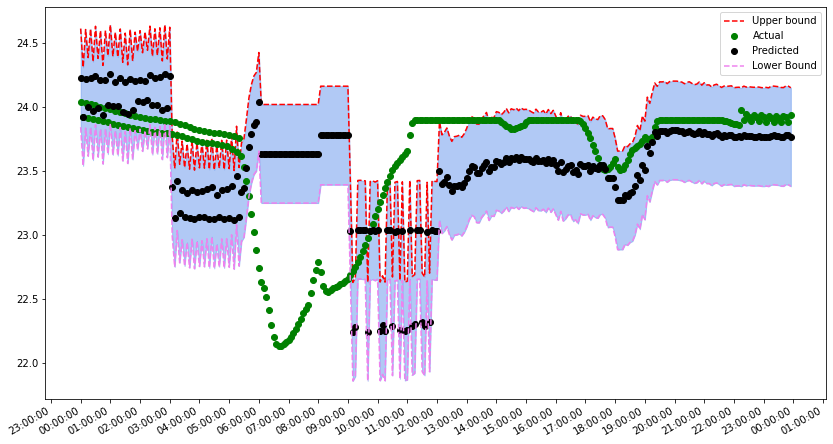

In [122]:
fig, ax = plt.subplots()
hours = mdates.HourLocator(interval = 1)
h_fmt = mdates.DateFormatter('%H:%M:%S')

ax.plot(bounds.index, bounds['upper'].values, '--', color = 'red', label = 'Upper bound')
ax.plot(bounds.index, bounds['zone_temp'].values, 'o', color = 'green', label = 'Actual')
ax.plot(bounds.index, bounds['pred'].values, 'o', color = 'black', label = 'Predicted')
ax.plot(bounds.index, bounds['lower'].values, '--', color = 'violet', label = 'Lower Bound')

#Then tick and format with matplotlib:
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)

fig.autofmt_xdate()
fig.set_size_inches(14, 8)
plt.fill_between(bounds.index, bounds['upper'].values,bounds['lower'].values,color='cornflowerblue',alpha=.5)
plt.legend()
plt.show()

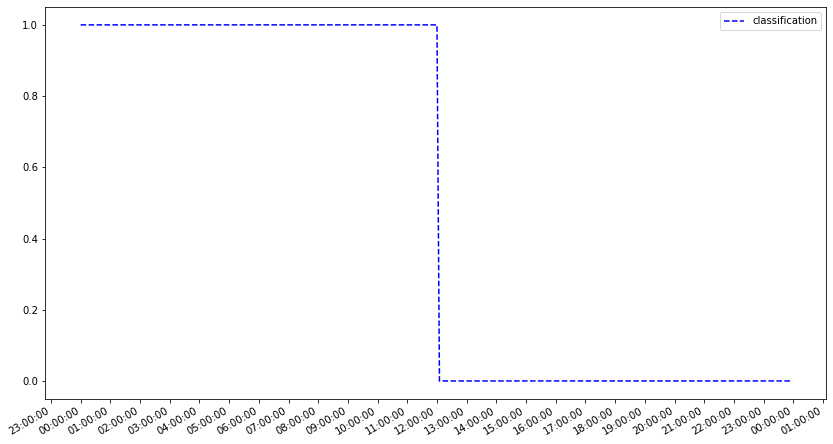

In [121]:
fig, ax = plt.subplots()
hours = mdates.HourLocator(interval = 1)
h_fmt = mdates.DateFormatter('%H:%M:%S')

ax.plot(bounds.index, bounds['classification'].values, '--', color = 'blue', label = 'classification')

#Then tick and format with matplotlib:
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)

fig.autofmt_xdate()
fig.set_size_inches(14, 8)
plt.legend()
plt.show()